In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import lstsq
from numpy import log,exp


## 1. Load Data and Create a Time Vector

- **Data Loading:**  
  We load the measured deck displacement data from a CSV file. (Make sure to update the CSV filename and the column name according to your file.)

- **Time Vector Creation:**  
  Since the total simulation time is known (73.343 seconds) and the data are uniformly sampled, we generate a time vector using `np.linspace`. For example, if there are _N_ samples, the time vector will range from 0 to 73.343 seconds.

In [2]:
# Replace "ground_truth.csv" with your file name and the column name accordingly.
data_pose = pd.read_csv("ground_truth.csv")
y = data_pose['field.pose.pose.position.z'].to_numpy()  # Use to_numpy() instead of .numpy()
y = y.flatten()  # Ensure it's a 1D array
N = len(y)

# Total simulation time is given as 73.343 seconds.
total_time = 73.343
# Create a time vector with N points linearly spaced between 0 and total_time.
t = np.linspace(0, total_time, N)
# Compute the sampling period.
T = t[1] - t[0]
print(f"Loaded {N} samples with total simulation time = {total_time:.3f} s and sampling period = {T:.4f} s.")

Loaded 7332 samples with total simulation time = 73.343 s and sampling period = 0.0100 s.


## 2. Center the Data

- **Purpose:**  
  The data may contain a constant offset. We subtract the mean from the data to focus on the dynamic variations. This also helps prevent the fitting procedure from forcing a large constant (polynomial) term.

In [3]:
# Subtract the mean to remove the constant offset before model fitting.
y_mean = np.mean(y)
y_centered = y - y_mean



## 3. Build the Linear Prediction Model (LPM)

**Assumption**  
We assume that the centered signal $y_{\text{centered}}[k]$ can be approximated by a linear combination of its previous $n$ values:

$$
y_{\text{centered}}[k] \;\approx\; a_1\,y_{\text{centered}}[k-1] \;+\; a_2\,y_{\text{centered}}[k-2] \;+\; \dots \;+\; a_n\,y_{\text{centered}}[k-n].
$$

**Implementation**  
We construct a regression matrix $Q$ (with each row containing $\big[\,y(k-1),\; y(k-2),\; \dots,\; y(k-n)\,\big]$) and a target vector $D$ (containing $y(k)$).  

We then solve the equation:

$$
Q \cdot A = D
$$

using least squares to estimate the coefficients

$$
A = \big[\,a_1,\; a_2,\; \dots,\; a_n\,\big].
$$


In [4]:
## We assume that y_centered[k] ≈ a1*y_centered[k-1] + a2*y_centered[k-2] + ... + an*y_centered[k-n]
# Choose the model order n (try n=4; you can experiment with n=2,3,4,...)
n = 4
# Build the regression matrix Q and target vector D
Q = []
D = []
for k in range(n, N):
    # Use the previous n samples (in reverse order: most recent first)
    Q.append(y_centered[k - n:k][::-1])
    D.append(y_centered[k])
Q = np.array(Q)
D = np.array(D)
# Solve for the coefficients A = [a1, a2, ..., an] using least squares.
A, residuals, rank, s = lstsq(Q, D, rcond=None)
print("Estimated LPM coefficients (A):", A)

Estimated LPM coefficients (A): [ 3.37536207 -4.13886543  2.15119892 -0.38769659]


## 4. Compute the Poles

- **Characteristic Polynomial**  
  The coefficients $A$ form the polynomial:

  $$
  z^n \;-\; a_1\,z^{n-1} \;-\; a_2\,z^{n-2} \;-\;\dots\;-\;a_n \;=\; 0.
  $$

  Solving for $z$ gives the **discrete-time poles**.

- **Conversion**  
  The continuous-time poles $\lambda$ are obtained using the relation

  $$
  \lambda \;=\; \frac{\ln(z)}{T},
  $$

  where $T$ is the sampling period.



In [5]:
coeffs = np.concatenate(([1], -A))
z_roots = np.roots(coeffs)
print("Discrete-time poles (z):", z_roots)
# Convert discrete-time poles to continuous-time poles using λ = ln(z) / T.
lambda_vals = np.log(z_roots) / T
print("Continuous-time poles (lambda):", lambda_vals)

Discrete-time poles (z): [0.99752617+0.j         0.9912778 +0.02479994j 0.9912778 -0.02479994j
 0.39528031+0.j        ]
Continuous-time poles (lambda): [ -0.24757842+0.j          -0.8443809 +2.50016791j
  -0.8443809 -2.50016791j -92.7742497 +0.j        ]


## 5. Compute the Residues

- **Vandermonde Matrix**  
  We construct a Vandermonde matrix $\Psi$ of size $(N \times n)$, where each row $k$ is given by:

  $$
  \Psi(k,:) = \bigl[z_1^k,\; z_2^k,\; \dots,\; z_n^k\bigr].
  $$

- **Residue Calculation**  
  We solve the linear system

  $$
  \Psi \cdot B \approx y_{\text{centered}}
  $$

  in a least-squares sense to obtain the residues

  $$
  B = \bigl[B_1,\; B_2,\; \dots,\; B_n\bigr].
  $$


In [6]:
# The model is: y_centered[k] ≈ sum_{i=1}^{n} B_i * z_i^k.
# We build a Vandermonde matrix Ψ of size (N x n) with Ψ[k,i] = z_roots[i]^k.
Psi = np.vander(z_roots, N, increasing=True).T  # Shape (N, n)
# Solve for the residues B in a least-squares sense:
B, residuals_B, rank_B, s_B = lstsq(Psi, y_centered, rcond=None)
print("Estimated residues (B):", B)

Estimated residues (B): [-0.08795774+4.45707164e-18j -0.01048029+6.52422669e-03j
 -0.01048029-6.52422669e-03j -0.01494477+3.21194894e-17j]


## 6. Signal Reconstruction

- **Centered Signal**  
  The reconstructed (centered) signal is:

  $$
  \hat{y}_{\text{centered}}(t) \;=\; \sum_{i=1}^{n} B_i \,\exp(\lambda_i\,t).
  $$

- **Add the Mean**  
  After reconstructing the centered signal, we add back the mean to get $\hat{y}(t)$


In [7]:
# Reconstruct the centered signal using the estimated modes:
y_hat_centered = np.zeros(N, dtype=complex)
for i in range(n):
    y_hat_centered += B[i] * np.exp(lambda_vals[i] * t)
# The full reconstructed signal:
y_hat = y_hat_centered.real + y_mean

## 7. Extract the Dominant Trend

**Dominant Modes:**  
We assume that the slowly varying trend is captured by those modes whose continuous-time poles have sufficiently negative real parts. In other words, we select only those indices $i$ for which

$$
\mathrm{Re}(\lambda_i) < -\varepsilon,
$$

where $\varepsilon$ is a small positive constant.

**Trend Reconstruction:**  
The dominant trend is then reconstructed as

$$
\hat{y}_{\text{trend}}(t) = \sum_{i \in \mathcal{D}} B_i\, e^{\lambda_i\,t} \;+\; \text{mean},
$$

where $\mathcal{D}$ is the set of indices satisfying $\mathrm{Re}(\lambda_i) < -\varepsilon$.

*Note:* If no mode satisfies this condition, we simply use all modes.



In [8]:
# For the dominant (slow-varying) trend, select modes with sufficiently negative real parts.
# Here we select indices where the real part of lambda is less than -1e-4.
dom_indices = np.where(np.real(lambda_vals) < -1e-4)[0]
if len(dom_indices) == 0:
    print("No modes with sufficiently negative real parts found. Using all modes.")
    dom_indices = np.arange(n)
    
dominant_trend_centered = np.zeros(N, dtype=complex)
for i in dom_indices:
    dominant_trend_centered += B[i] * np.exp(lambda_vals[i] * t)
dominant_trend = dominant_trend_centered.real + y_mean

## 8. Plot the Results

We typically plot three curves on the same figure:

1. **Measured Data** (e.g., green markers)
2. **Full Prony Model Reconstruction** (e.g., red solid line)
3. **Dominant Trend** (e.g., blue dashed line)

This allows us to compare the raw measurements, the full exponential fit, and the slow-varying trend extracted from the data.


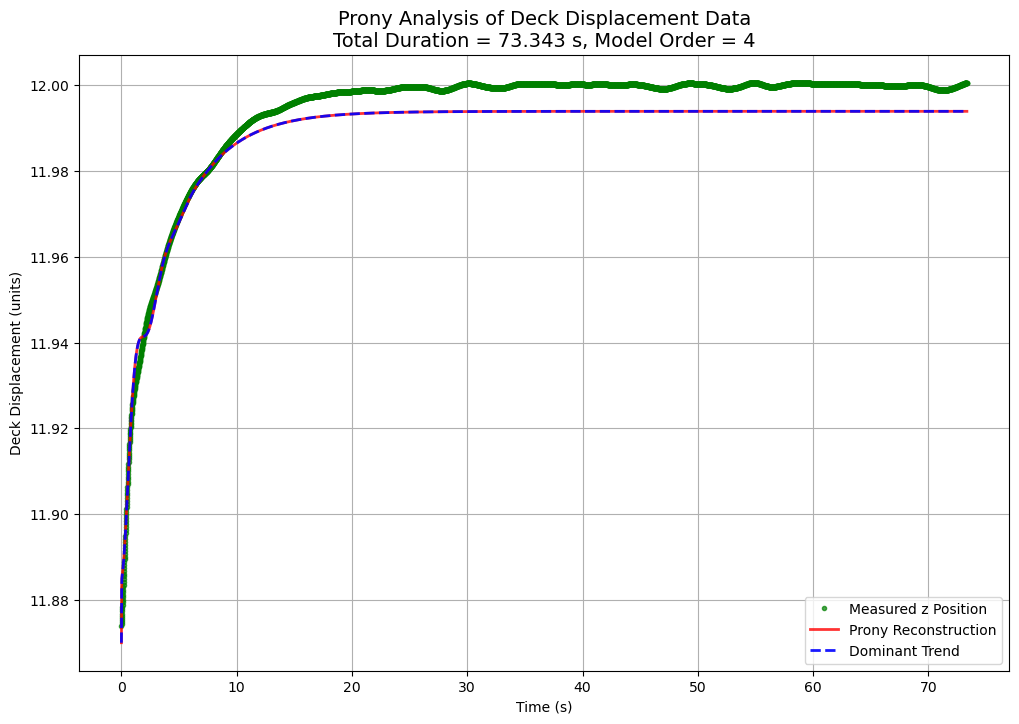

In [9]:
plt.figure(figsize=(12, 8))
# Plot measured data (green circles)
plt.plot(t, y, 'go', markersize=3, alpha=0.7, label='Measured z Position')
# Plot full Prony model reconstruction (red solid line)
plt.plot(t, y_hat, 'r-', linewidth=2, alpha=0.8, label='Prony Reconstruction')
# Plot dominant trend (blue dashed line)
plt.plot(t, dominant_trend, 'b--', linewidth=2, alpha=0.9, label='Dominant Trend')
plt.xlabel('Time (s)')
plt.ylabel('Deck Displacement (units)')
plt.title(f'Prony Analysis of Deck Displacement Data\nTotal Duration = {total_time:.3f} s, Model Order = {n}', fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.show()
